In [10]:
import sys, os, glob
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.append('../src/')
from training import train_spotwise, train_gridwise
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from count_datasets import CountDataset, CountGridDataset
from gridnet_models import GridNetHexOddr
from plotting import performance_curves
from utils import all_fgd_predictions

In [2]:
# Extract principal components from normalized count data.
data_dir = os.path.expanduser('~/Documents/Splotch_projects/Maynard_DLPFC/data/')

X = []
for cfile in glob.glob(os.path.join(data_dir, 'Countfiles_Visium_norm', '*.unified.tsv')):
    count_dat = pd.read_csv(cfile, sep='\t', header=0, index_col=0)
    X.append(count_dat.values.T)

X = np.vstack(X)
print(X.shape)

#pca = PCA()
#pca.fit(X)

pca = pickle.load(open('../models/trained_pca.pkl', 'rb'))

(47329, 11297)


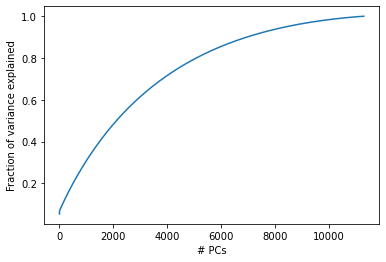

In [3]:
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# PCs')
plt.ylabel('Fraction of variance explained')
plt.show()

In [4]:
np.sum(pca.explained_variance_ratio_[:2150])

0.5047220707398039

In [5]:
# Construct training and validation sets from PCA-trained data
train_tissues = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674']
val_tissues = ['151675', '151676']

countfiles_train = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in train_tissues]
annotfiles_train = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in train_tissues]

countfiles_val = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in val_tissues]
annotfiles_val = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in val_tissues]

NUM_PCS = 2150

# Save PCs for each input array
for cf in countfiles_train + countfiles_val:
    count_dat = pd.read_csv(cf, header=0, index_col=0, sep='\t')
    X = pca.transform(count_dat.values.T)[:, :NUM_PCS]
    
    df = pd.DataFrame(X.T, columns=count_dat.columns, index=['PC%d' % i for i in range(NUM_PCS)])
    df.to_csv(cf.replace('.txt.unified.tsv', '_PCs.tsv'), sep='\t')
    
pcafiles_train = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs_PCs.tsv') % s for s in train_tissues]
pcafiles_val = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs_PCs.tsv') % s for s in val_tissues]

# Load full dataset into memory (though we most likely won't be able to do this on GPUs)
train_spot_pca = load_count_dataset(pcafiles_train, annotfiles_train)
val_spot_pca = load_count_dataset(pcafiles_val, annotfiles_val)

dataloader_spot_pca = {
    'train': DataLoader(train_spot_pca, batch_size=32, shuffle=True),
    'val': DataLoader(val_spot_pca, batch_size=32)
}

Epoch 0/39
----------
train Loss: 1.0030 Acc: 0.6807
val Loss: 0.7983 Acc: 0.7046

Epoch 1/39
----------
train Loss: 0.5861 Acc: 0.7924
val Loss: 0.7450 Acc: 0.7195

Epoch 2/39
----------
train Loss: 0.4640 Acc: 0.8337
val Loss: 0.7948 Acc: 0.7069

Epoch 3/39
----------
train Loss: 0.3515 Acc: 0.8800
val Loss: 0.8519 Acc: 0.7014

Epoch 4/39
----------
train Loss: 0.2383 Acc: 0.9256
val Loss: 0.9195 Acc: 0.6957

Epoch 5/39
----------
train Loss: 0.1631 Acc: 0.9523
val Loss: 1.0024 Acc: 0.6892

Epoch 6/39
----------
train Loss: 0.1104 Acc: 0.9705
val Loss: 1.1244 Acc: 0.6879

Epoch 7/39
----------
train Loss: 0.0926 Acc: 0.9739
val Loss: 1.2185 Acc: 0.6791

Epoch 8/39
----------
train Loss: 0.0768 Acc: 0.9778
val Loss: 1.2875 Acc: 0.6831

Epoch 9/39
----------
train Loss: 0.0686 Acc: 0.9792
val Loss: 1.4244 Acc: 0.6726

Epoch 10/39
----------
train Loss: 0.0581 Acc: 0.9833
val Loss: 1.4133 Acc: 0.6806

Epoch 11/39
----------
train Loss: 0.0588 Acc: 0.9814
val Loss: 1.5079 Acc: 0.6747

Ep

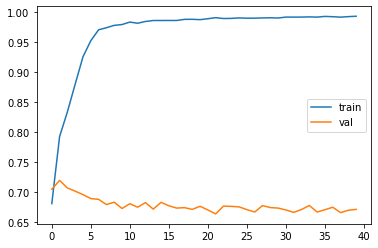

In [6]:
# Fit a basic fully-connected network to the top 2150 PCs (50% of variance)
df = pd.read_csv(annotfiles_train[0], header=0, index_col=0, sep='\t')
annot_names = list(df.index.values)

spot_clf_pca = nn.Sequential(
    nn.Linear(NUM_PCS, 500),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    
    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    
    nn.Linear(50, len(annot_names))
)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(spot_clf_pca.parameters(), lr=1e-4)

spot_clf_pca, val_hist, train_hist = train_spotwise(spot_clf_pca, dataloader_spot_pca, loss, optimizer, 40, 
                                                    display=False, outfile='../models/spot_classifier_pca.pth')

fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()

In [7]:
# Try training a g network on top of the PC-based spot classifier
train_grid_pca = load_count_grid_dataset(pcafiles_train, annotfiles_train)
val_grid_pca = load_count_grid_dataset(pcafiles_val, annotfiles_val)

dataloader_grid_pca = {
    'train': DataLoader(train_grid_pca, batch_size=1, shuffle=True),
    'val': DataLoader(val_grid_pca, batch_size=1, shuffle=False)
}

Epoch 0/99
----------
train Loss: 20.3865 Acc: 0.4275
val Loss: 6.9499 Acc: 0.6280

Epoch 1/99
----------
train Loss: 2.7733 Acc: 0.7762
val Loss: 3.3596 Acc: 0.7040

Epoch 2/99
----------
train Loss: 1.6902 Acc: 0.8362
val Loss: 3.6098 Acc: 0.7353

Epoch 3/99
----------
train Loss: 1.3296 Acc: 0.8606
val Loss: 3.1690 Acc: 0.7347

Epoch 4/99
----------
train Loss: 1.1176 Acc: 0.8753
val Loss: 2.7165 Acc: 0.7582

Epoch 5/99
----------
train Loss: 0.9810 Acc: 0.8854
val Loss: 2.9330 Acc: 0.7503

Epoch 6/99
----------
train Loss: 0.8999 Acc: 0.8889
val Loss: 2.6409 Acc: 0.7559

Epoch 7/99
----------
train Loss: 0.8281 Acc: 0.8906
val Loss: 2.2753 Acc: 0.7665

Epoch 8/99
----------
train Loss: 0.7590 Acc: 0.8926
val Loss: 2.2705 Acc: 0.7599

Epoch 9/99
----------
train Loss: 0.7104 Acc: 0.8926
val Loss: 1.9496 Acc: 0.7726

Epoch 10/99
----------
train Loss: 0.6993 Acc: 0.8931
val Loss: 2.2423 Acc: 0.7460

Epoch 11/99
----------
train Loss: 0.6707 Acc: 0.8940
val Loss: 1.9994 Acc: 0.7609

E

val Loss: 0.8761 Acc: 0.8076

Epoch 98/99
----------
train Loss: 0.1686 Acc: 0.9416
val Loss: 0.9585 Acc: 0.7908

Epoch 99/99
----------
train Loss: 0.1426 Acc: 0.9471
val Loss: 0.7825 Acc: 0.8146

Training complete in 3m 57s
Best val Acc: 0.814635


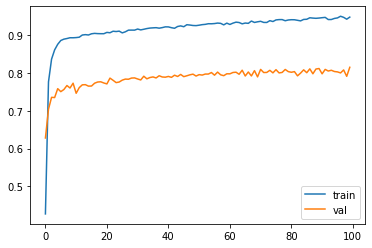

In [8]:
H_VISIUM = 78
W_VISIUM = 64
gnet_pca = GridNetHexOddr(spot_clf_pca, (NUM_PCS,), (H_VISIUM, W_VISIUM), n_classes=len(annot_names),
                 use_bn=False)

# Fixing the parameters of the patch classifier allows slightly faster training, even when only
#   optimizing the parameters of the corrector. 
for param in gnet_pca.patch_classifier.parameters():
    param.requires_grad = False

loss = nn.CrossEntropyLoss()

# Only optimize the parameters in the g-network
optimizer = torch.optim.Adam(gnet_pca.corrector.parameters(), lr=1e-3)

gnet_pca, val_hist, train_hist = train_gridwise(gnet_pca, dataloader_grid_pca, loss, optimizer, num_epochs=100,
                                  outfile='../models/gnet_pca.pth')

fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()

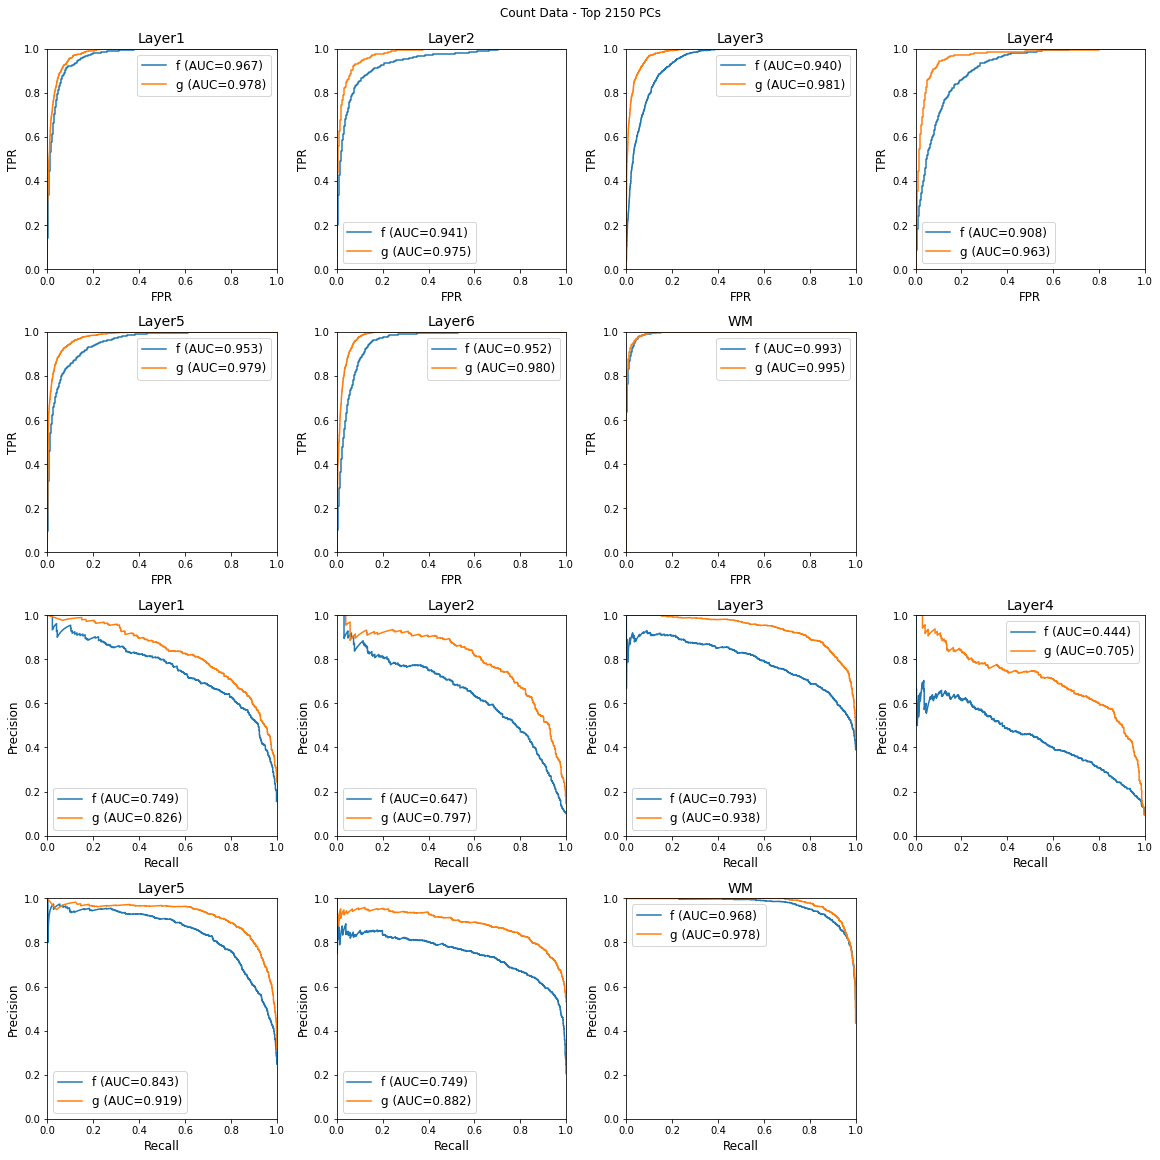

f predictions - count PCA
ACC: 0.719, MACRO_AUROC: 0.951, MACRO_AUPRC: 0.742
g predictions - count PCA
ACC: 0.815, MACRO_AUROC: 0.979, MACRO_AUPRC: 0.864


In [11]:
# Examine ROC, precision-recall performance of f, g models trained on PCs of count data

# f_PCA
true_vals, patch_preds_pca, patch_smax_pca = all_fgd_predictions(dataloader_grid_pca['val'], gnet_pca, f_only=True)

# g_PCA
_, grid_preds_pca, grid_smax_pca = all_fgd_predictions(dataloader_grid_pca['val'], gnet_pca)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [patch_smax_pca, grid_smax_pca], annot_names, ['f','g'])
fig.suptitle('Count Data - Top 2150 PCs')
plt.show()

acc = np.sum(patch_preds_pca == true_vals) / len(true_vals)

print('f predictions - count PCA')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[0], macro_auprc[0]))

acc = np.sum(grid_preds_pca == true_vals) / len(true_vals)

print('g predictions - count PCA')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[1], macro_auprc[1]))

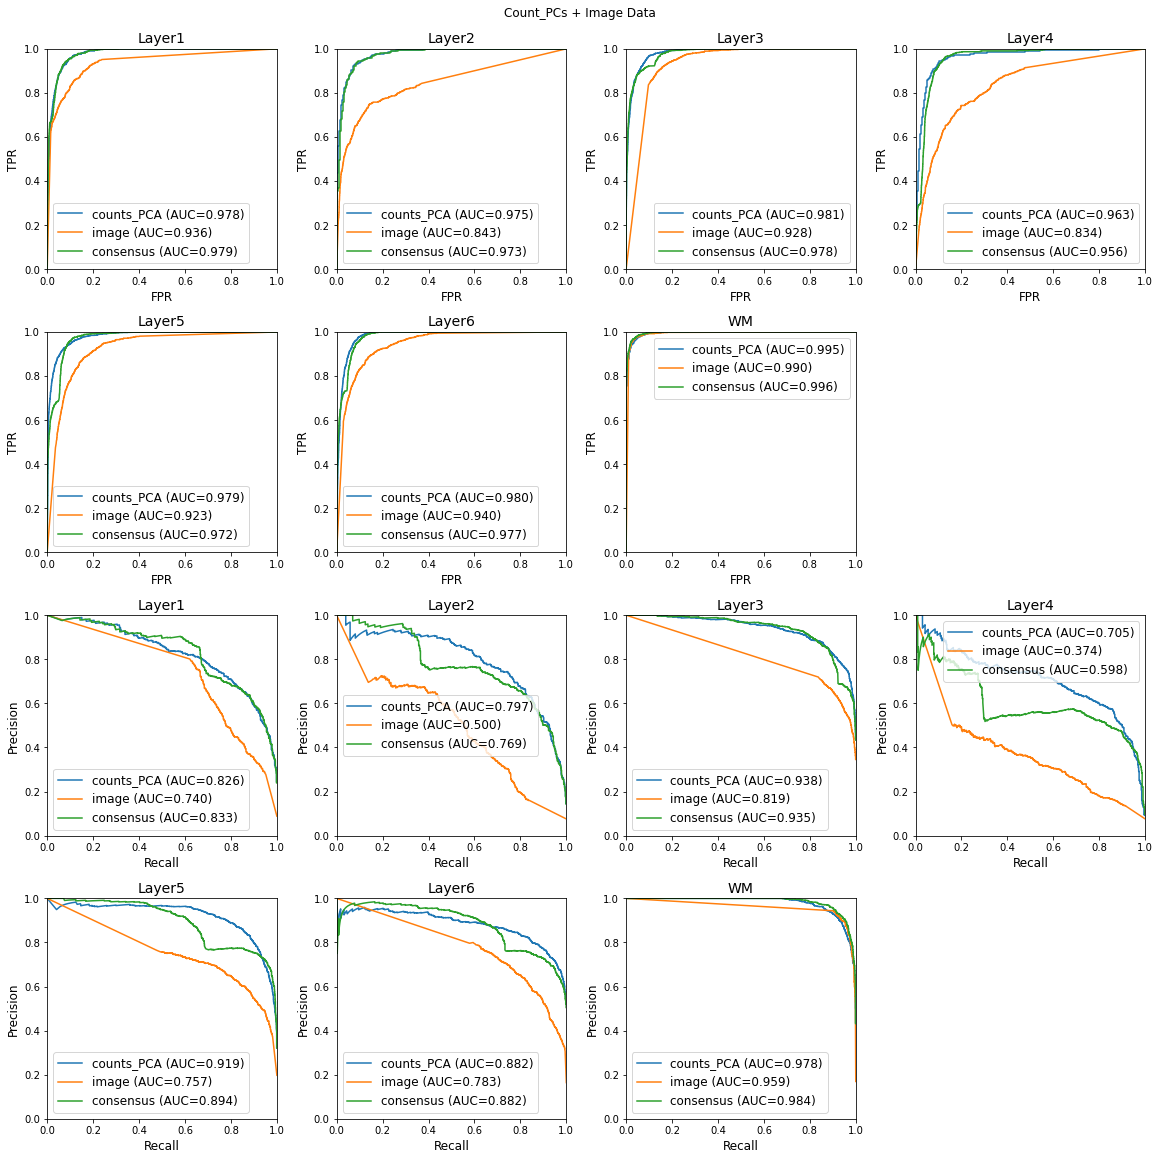

g predictions (consensus) - count_pca + image data
ACC: 0.745, MACRO_AUROC: 0.976, MACRO_AUPRC: 0.842


In [13]:
# Now see what happens if we try making a consensus predictor using image data as well:

# f_img:
patch_smax_img = np.load('../outputs/maynard_imgpred_fgd/maynard_smax_f_6fold_5_oddr.npy')

# g_img:
grid_smax_img = np.load('../outputs/maynard_imgpred_fgd/maynard_smax_g_6fold_5_oddr.npy')

# Create consensus prediction
consensus_smax = np.array((grid_smax_pca, grid_smax_img)).mean(axis=0)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [grid_smax_pca, grid_smax_img, consensus_smax], 
                                                       annot_names, ['counts_PCA', 'image', 'consensus'])
fig.suptitle('Count_PCs + Image Data')
plt.show()

consensus_pred = np.argmax(consensus_smax, axis=1)
acc = np.sum(consensus_pred == true_vals) / len(true_vals)

print('g predictions (consensus) - count_pca + image data')
print('ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc, macro_auroc[2], macro_auprc[2]))